# 0. Применение метода KNN для решения задачи классификации

Набор данных получен в результате переписи населения 1994 года и содержит информацию о некотором количестве людей, проживающих в США. Задача состоит в том, чтобы предсказать, зарабатывает человек более $50к в год или нет. Список признаков:

*   <b>age</b>: возраст человека.
*   <b>workclass</b>: статус занятости.
*   <b>fnlwgt</b>: количество людей, которое, по мнению переписи, представляет запись.
*   <b>education</b>: высший уровень образования, достигнутый человеком.
*   <b>education-num</b>: высший уровень образования, достигнутый человеком в числовой форме.
*   <b>marital-status</b>: семейное положение человека.
*   <b>occupation</b>: общий род занятий человека.
*   <b>relationship</b>: представляет то, чем этот человек является по отношению к другим (перекликается с признаком <b>marital-status</b>).
*   <b>race</b>: раса.
*   <b>sex</b>: пол.
*   <b>capital-gain</b>: прирост капитала.
*   <b>capital-loss</b>: убыток капитала.
*   <b>hours-per-week</b>: число рабочих часов в неделю.
*   <b>native-country</b>: страна происхождения.
*   <b>the label</b>: отклик -- зарабатывает больше $50к или меньше.



## Немного про метрики качества модели

Для начала рассмотрим так называемую матрицу ошибок (confusion matrix)
-- способ разделить объекты на $4$ группы в зависимости от комбинации
истинного класса и ответа классификатора:

-   TP (True Positives) -- верно классифицированные объекты, исходно     относящиеся к классу "$+1$";

-   TN (True Negatives) -- верно классифицированные объекты, исходно     относящиеся к классу "$-1$";

-   FN (False Negatives) -- неверно классифицированные объекты, исходно     относящиеся к классу "$+1$" (ошибка I рода);

-   FP (False Positives) -- неверно классифицированные объекты, исходно     относящиеся к классу "$-1$" (ошибка II рода).

Обычно, конечно, оперируют не абсолютными показателями, а относительными
-- долями (rates), находящимися в диапазоне от $0$ до $1$:

-   доля правильных ответов классификатора (иногда -- точность): $$\mathsf{Accuracy} = \frac{TP + TN}{TP + FP + FN + TN}.$$ Эта величина показывает отношение количества верно классифицированных объектов к общему количеству классифицируемых объектов и, грубо говоря, оценивает вероятность случайному объекту быть правильно классифицированным.

-   доля истинно положительных примеров -- True Positives Rate (TPR) или     Sensitivity (чувствительность) или Recall: $$\mathsf{T P R}=\frac{T P}{T P+F N}.$$ Эта величина показывает отношение количества верно классифицированных объектов, относящихся к классу "$+1$", к общему количеству объектов класса "$+1$". Иными словами -- это оценка вероятности, что объект, относящийся к классу "$+1$" будет классифицирован корректно.

-   доля ложно положительных примеров обозначается как -- False Positives Rate (FPR): $$\mathsf{F P R}=\frac{F P}{FP + TN}.$$ Величина показывает отношение количества неверно классифицированных объектов, относящихся к классу "$-1$", к общему количеству объектов класса "$-1$", или оценивает вероятность, что объект, относящийся к классу "$-1$", будет классифицирован неверно.

-   Специфичность (Specificity) или True Negatives Rate (TNR): $$\mathsf{TNR} = 1 - \mathsf{F P R} =\frac{T N}{T N+F P}.$$ Величина показывает отношение количества верно классифицированных объектов, относящихся к классу "$-1$", к общему количеству объектов класса "$-1$", или оценивает вероятность, что объект, относящийся к классу "$-1$", будет классифицирован верно.

-   Precision (точность): $$\mathsf{Precision} =\frac{TP}{TP + FP}.$$ Величина показывает, какая доля объектов, отнесенных классификатором к классу "$+1$", действительно относится к этому классу.

Естественно возникает вопрос, нет ли какого-то обобщающего критерия,
который может характеризовать качество построенной модели. Один из них --
так называемая $F$-мера ($F_1$-мера, $F$ score, $F_1$ score)
определяется следующим соотношением:
$$F = F_1 = 2 \cdot \frac{\mathsf{Precision} \cdot \mathsf{Recall}}{\mathsf{Precision} + \mathsf{Recall}}.$$

**Замечание**. *$F$-мера является средним гармоническим величин
$\mathsf{Precision}$ и $\mathsf{Recall}$ и заключена в диапазоне
$[0, 1]$. Среднее гармоническое обладает важным свойством: оно близко к
нулю, если хотя бы один из аргументов близок к нулю. Поэтому оно является
куда более предпочтительным, чем, скажем, среднее арифметическое: если
алгоритм относит все объекты к положительному классу, то
$\mathsf{Recall}= 1$, а $\mathsf{Precision}$, скорее всего, будет
небольшим. Но тогда среднее арифметическое будет больше, чем $0.5$, что,
конечно, никуда не годится.*

## Импорт библиотек и чтение набора данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
import seaborn as sns
from matplotlib import pyplot as plt

Считайте набор данных в датафрейм. Исходя из описания признаков можно сразу избавиться от признаков <code>education</code> и <code>marital-status</code>. Удалите соответствующие колонки из набора данных.

In [2]:
df = pd.read_csv('https://dc-edu.itmo.ru/assets/courseware/v1/3b5e697be14f493785e3d21577f9fcb3/asset-v1:ITMO+bonus_track_methods+2023+type@asset+block/adult_data_train.csv')
df = df.drop(columns=['education', 'marital-status'])
df

,age,workclass,fnlwgt,education-num,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,32,Private,37210,13,Exec-managerial,Husband,White,Male,0,0,45,United-States,1
1,43,Private,101950,14,Exec-managerial,Not-in-family,White,Female,0,0,45,United-States,0
2,20,?,122244,9,?,Not-in-family,White,Female,0,0,28,United-States,0
3,40,Local-gov,24763,10,Transport-moving,Unmarried,White,Male,6849,0,40,United-States,0
4,24,Private,113936,13,Prof-specialty,Own-child,White,Male,0,0,40,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26043,35,Self-emp-not-inc,179171,9,Sales,Unmarried,Black,Female,0,0,38,Germany,0
26044,39,Private,421633,10,Protective-serv,Unmarried,Black,Female,0,0,30,United-States,0
26045,55,Private,82098,9,Exec-managerial,Husband,Asian-Pac-Islander,Male,0,0,55,United-States,0
26046,26,Private,50053,13,Exec-managerial,Husband,White,Male,0,0,55,United-States,0


Определите количество числовых и нечисловых признаков.

In [3]:
numeric = df.select_dtypes(include=['number']).columns
non_numeric = df.select_dtypes(exclude=['number']).columns
print(f'Кол-во числовых признаков: {len(numeric)}')
print(f'Кол-во нечисловых признаков: {len(non_numeric)}')

Кол-во числовых признаков: 7
Кол-во нечисловых признаков: 6


Постройте гистограмму распределения объектов по классам. Вычислите долю объектов класса $0$.

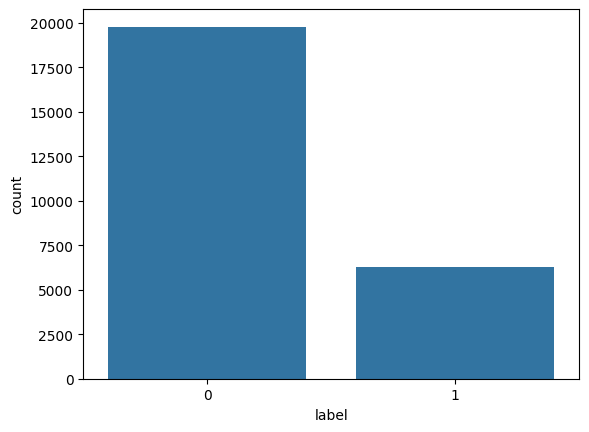

In [4]:
# строим гистограмму распределения объектов по классам
sns.countplot(df, x='label')
plt.show()

In [5]:
# вычисляем долю объекта класса 0
round(df['label'].value_counts()[0] / len(df), 3)

0.759

# 1. Построение базовой модели

В качестве первого приближения имеет смысл построить модель классификации, опираясь исключительно на числовые признаки.

Отберите из набора данных только числовые признаки. При помощи <code>train_test_split()</code> разбейте набор данных на обучающую и тестовую выборки <b>с параметрами, указанными в вашем задании</b>. Используйте стратификацию по колонке <code>label</code>.

Вычислите выборочное среднее колонки <code>fnlwgt</code> тренировочного набора данных.

Обучите модель <code>KNeighborsClassifier()</code> с параметрами по умолчанию на тренировочных данных.

Как видно из предыдущего пункта, в наборе данных наблюдается явный дисбаланс представителей классов. Это следует учесть при оценке модели. Вычислите <code>f1_score</code> модели на тестовых данных (рекомендуем использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html">соответствующую функцию</a> с параметрами по умолчанию.

В качестве альтернативы можно использовать так называемый <a href = "https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html"><code>classification_report()</code></a>, где приведены сразу несколько метрик (не стоит забывать про параметр <code>digits</code>).

In [6]:
# отбираем только числовые признаки
df_numeric = df[numeric]
df_numeric.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,label
0,32,37210,13,0,0,45,1
1,43,101950,14,0,0,45,0
2,20,122244,9,0,0,28,0
3,40,24763,10,6849,0,40,0
4,24,113936,13,0,0,40,0


In [7]:
# разбиваем набор данных на тестовую и обучающую выборки
X_train, X_test, y_train, y_test = train_test_split(df_numeric.drop(columns=['label']), df_numeric['label'], test_size=0.2, random_state=27, stratify=df_numeric['label'])

print('Shapes', '    X', '       y')
print('train', X_train.shape, y_train.shape)
print('test ', X_test.shape, y_test.shape)

Shapes     X        y
train (20838, 6) (20838,)
test  (5210, 6) (5210,)


In [8]:
# вычисляем выборочное среднее колонки fnlwgt
round(X_train['fnlwgt'].mean(), 3)

190021.844

In [9]:
# строим модель k-NN
knn = KNeighborsClassifier().fit(X_train, y_train)
prediction = knn.predict(X_test)

print(f'f1 score: {round(f1_score(y_test, prediction), 3)}')

f1 score: 0.388


Стоит помнить, что KNN является метрическим классификатором, поэтому значения признаков перед обучением модели следует нормировать.

Обучите преобразование <code>MinMaxScaler()</code> на тренировочном наборе данных и примените его для тренировочных и тестовых данных.

Вычислите выборочное среднее колонки <code>fnlwgt</code> тренировочного набора данных после нормировки.

Заново обучите и оцените модель на преобразованных данных. Вычислите <code>f1_score()</code> модели.

In [10]:
# применим MinMaxScaler
scaler = MinMaxScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [11]:
# вычисляем выборочное среднее колонки fnlwgt
round(X_train['fnlwgt'].mean(), 3)

0.121

In [12]:
# строим модель k-NN
knn = KNeighborsClassifier().fit(X_train, y_train)
prediction = knn.predict(X_test)

print(f'f1 score: {round(f1_score(y_test, prediction), 3)}')

f1 score: 0.518


Видно, что после линейной нормировки качество выросло.

<b>Важно: </b>На дальнейших этапах подразумевается использование линейной нормировки непосредственно перед обучением без дополнительных напоминаний.

# 2. Работа с нечисловыми признаками

## Визуализация

Для дальнейшего улучшения качества модели имеет смысл задействовать нечисловые признаки исходного датасета (без колонок <code>education</code> и <code>marital-status</code>).

Постройте гистограммы, иллюстрирующие частоту того или иного значения по каждому нечисловому признаку, например, при помощи <code>sns.barplot()</code>.

In [13]:
# отбираем только нечисловые признаки
df_non_numeric = df[non_numeric]
df_non_numeric.head()

,workclass,occupation,relationship,race,sex,native-country
0,Private,Exec-managerial,Husband,White,Male,United-States
1,Private,Exec-managerial,Not-in-family,White,Female,United-States
2,?,?,Not-in-family,White,Female,United-States
3,Local-gov,Transport-moving,Unmarried,White,Male,United-States
4,Private,Prof-specialty,Own-child,White,Male,United-States


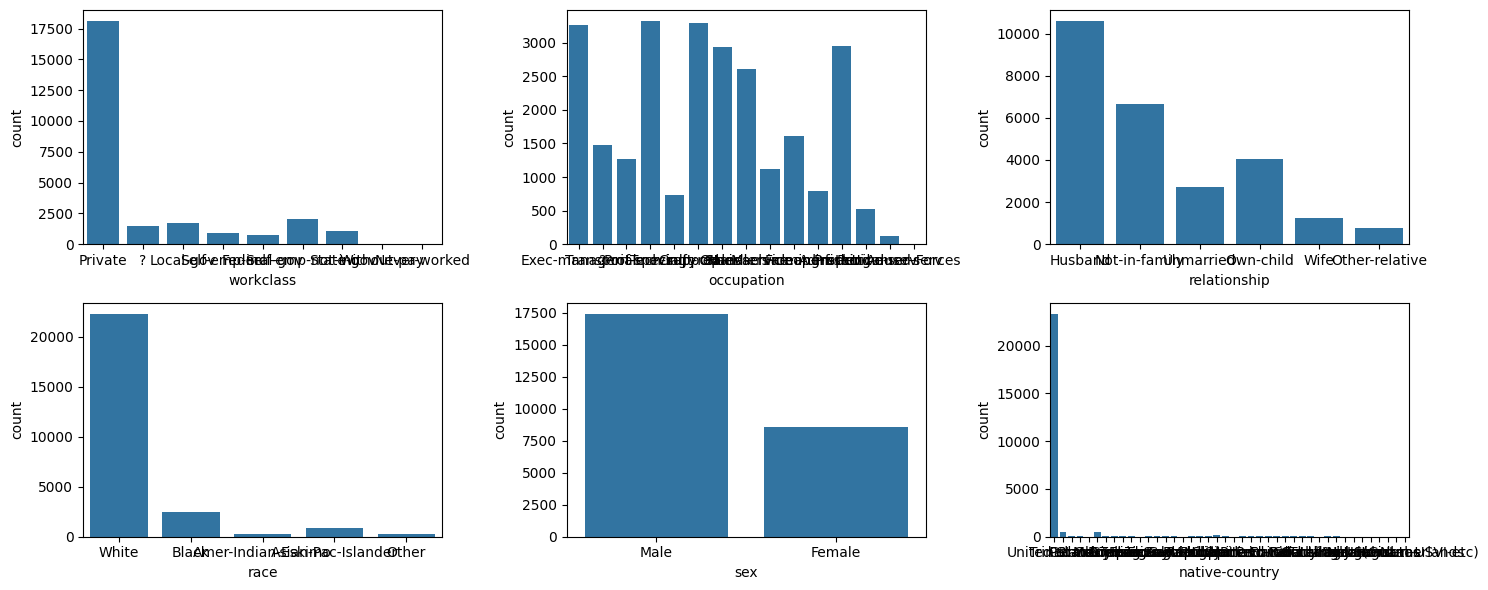

In [14]:
# cстроим гистограммы для каждого нечислового признака
fig, axes = plt.subplots(2, 3, figsize=(15, 6))

for ax, column in zip(axes.flat, non_numeric):
    sns.countplot(df_non_numeric, x=column, ax=ax)

plt.tight_layout()
plt.show()

## Удаление пропущенных значений

Определите число строк исходного набора данных (без колонок <code>education</code> и <code>marital-status</code>), в которых присутствует хотя бы одно пропущенное значение.

In [15]:
missed_rows = df[(df['workclass'] == '?') | (df['occupation'] == '?') | (df['native-country'] == '?')]
print(f'Число строк с пропущенными значениями: {len(missed_rows)}')

Число строк с пропущенными значениями: 1914


Видно, что в датасете содержится менее 10% строк, содержащих пропуски. Выкидывать такое количество строк — не очень хорошее дело, но почему бы не попробовать обойтись без них.

Удалите строки, содеражащие пропуски. Произведите <code>one-hot</code> кодировние нечисловых признаков, например, с помощью <code>pd.get_dummies(drop_first=True)</code>.

Введите число полученных признаков.

In [16]:
# удалим строки, содержащие пропуски
df_del = df.drop(missed_rows.index)

In [17]:
# произведем one-hot кодирование нечисловых признаков
dummies = pd.get_dummies(df_del[non_numeric], drop_first=True)
df_del = df_del.drop(columns=non_numeric)
df_del[dummies.columns] = dummies
print(f'Число полученных признаков: {len(df_del.columns) - 1}')

Число полученных признаков: 75


Обучите модель классификации аналогично тому, как это было проделано для базовой модели. Вычислите <code>f1_score()</code> модели.



In [18]:
# разбиваем набор данных на тестовую и обучающую выборки
X_train, X_test, y_train, y_test = train_test_split(df_del.drop(columns=['label']), df_del['label'], test_size=0.2, random_state=27, stratify=df_del['label'])

print('Shapes', '    X', '       y')
print('train', X_train.shape, y_train.shape)
print('test ', X_test.shape, y_test.shape)

Shapes     X        y
train (19307, 75) (19307,)
test  (4827, 75) (4827,)


In [19]:
# применим MinMaxScaler
scaler = MinMaxScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [20]:
# строим модель k-NN
knn = KNeighborsClassifier().fit(X_train, y_train)
prediction = knn.predict(X_test)

print(f'f1 score: {round(f1_score(y_test, prediction), 3)}')

f1 score: 0.61


Точность модели увеличилась по сравнению с моделью, которая использовала только числовые признаки.

## Заполнение пропущенных значений

Возможно точность еще повысится, если задействовать строки с пропущенными значениями. Используя исходный датасет (без колонок <code>education</code> и <code>marital-status</code>), заполните пропуски самым часто встречающимся значением в рамках столбца.

In [21]:
mis_replacer = SimpleImputer(missing_values = '?', strategy='most_frequent')
df_impute = pd.DataFrame(mis_replacer.fit_transform(df[non_numeric]), columns=df[non_numeric].columns)
df = df.drop(columns=non_numeric)
df = pd.concat([df, df_impute], axis=1)

Далее по уже знакомому сценарию: <code>one-hot</code>, <code>split</code>, <code>scaling</code>, обучение и оценка.

Вычислите <code>f1_score()</code> модели.

In [22]:
# произведем one-hot кодирование нечисловых признаков
dummies = pd.get_dummies(df[non_numeric], drop_first=True)
df = df.drop(columns=non_numeric)
df[dummies.columns] = dummies

In [23]:
# разбиваем набор данных на тестовую и обучающую выборки
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['label']), df['label'], test_size=0.2, random_state=27, stratify=df['label'])

print('Shapes', '    X', '       y')
print('train', X_train.shape, y_train.shape)
print('test ', X_test.shape, y_test.shape)

Shapes     X        y
train (20838, 76) (20838,)
test  (5210, 76) (5210,)


In [24]:
# применим MinMaxScaler
scaler = MinMaxScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [25]:
# строим модель k-NN
knn = KNeighborsClassifier().fit(X_train, y_train)
prediction = knn.predict(X_test)

print(f'f1 score: {round(f1_score(y_test, prediction), 3)}')

f1 score: 0.599


## Проклятие размерности

В последнем пункте был получен набор данных, содержащий 76 признаков (кстати, попробуйте объяснить, почему в случае удаления строк число признаков в итоге оказалось равным 75), что является достаточным для того, чтобы столкнуться с так называемым проклятием размерности.

Для того, чтобы классификатор давал более качественные результаты, имеет смысл более внимательно и вдумчиво поработать с признаками с учетом проклятия размерности. Например, вернуть в рассмотрение признаки <code>education-num</code> и <code>marital-status</code>. А также более глубоко вникнуть в саму природу признаков.